In [2]:
import fastai.vision.all as fai
import fastbook as faibook

fai.matplotlib.rc('image', cmap='Greys')
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
# simple example which predict number by binary pair

import torch

# Define sigmoid function (unchanged)
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Define simple mean squared error (MSE) loss function
def mse_loss(predictions, targets):
    # Calculate squared differences
    loss = (predictions - targets) ** 2
    return loss.mean()  # Return average loss

# Initialize dataset: [1, 0] for class 0 and [0, 1] for class 1
X = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # Inputs
y = torch.tensor([0.0, 1.0])  # Targets (0 = class 0, 1 = class 1)

# Initialize weights and bias manually
weights = torch.randn(2, requires_grad=True)  # Weights for 2 input features
bias = torch.randn(1, requires_grad=True)     # Single bias term

# Set learning rate
learning_rate = 0.1

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    
    # Forward pass: calculate the weighted sum (z = w1*x1 + w2*x2 + bias) and apply sigmoid
    
    z = X @ weights  # @ is matrix multiplication
    predictions = sigmoid(z)  # Apply sigmoid to get probabilities
    
    # Compute the simplified MSE loss
    loss = mse_loss(predictions, y)
    
    # Backward pass: manually compute gradients using autograd
    loss.backward()  # Compute gradients for weights and bias
    
    # Update weights and bias (gradient descent)
    with torch.no_grad():  # Disable gradient tracking for this part
        weights -= learning_rate * weights.grad  # Update weights
        # bias -= learning_rate * bias.grad        # Update bias
    
    # Zero the gradients after each step
    weights.grad.zero_()
    # bias.grad.zero_()

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Print trained weights and bias after training
print(f'Trained Weights: {weights}')
print(f'Trained Bias: {bias}')

inp = torch.tensor([1.0, 0.0])
# inp = torch.tensor([0.0, 1.0])
z = inp @ weights  # @ is matrix multiplication
print(z.item(), sigmoid(z).item())  # Apply sigmoid to get probabilities


Epoch [100/1000], Loss: 0.0928
Epoch [200/1000], Loss: 0.0453
Epoch [300/1000], Loss: 0.0283
Epoch [400/1000], Loss: 0.0201
Epoch [500/1000], Loss: 0.0154
Epoch [600/1000], Loss: 0.0124
Epoch [700/1000], Loss: 0.0104
Epoch [800/1000], Loss: 0.0089
Epoch [900/1000], Loss: 0.0077
Epoch [1000/1000], Loss: 0.0068
Trained Weights: tensor([-2.3950,  2.4174], requires_grad=True)
Trained Bias: tensor([0.2345], requires_grad=True)
-2.394956111907959 0.08355813473463058


In [4]:
# let's get images and transform them 
# to data with which we can work in NN, like this:
# Image -> [[0,0,255]] -> [[0.0, 0.0, 1.0]]

In [5]:
path_to_imgs = fai.untar_data(fai.URLs.MNIST_SAMPLE)
path_to_imgs

Path('/Users/mxz/.fastai/data/mnist_sample')

In [6]:
# we have some directories and files here
path_to_imgs.ls()

(#3) [Path('/Users/mxz/.fastai/data/mnist_sample/valid'),Path('/Users/mxz/.fastai/data/mnist_sample/labels.csv'),Path('/Users/mxz/.fastai/data/mnist_sample/train')]

In [7]:
# train paths
train_threes_path = (path_to_imgs/'train'/'3').ls().sorted()
train_sevens_path = (path_to_imgs/'train'/'7').ls().sorted()

train_threes_path[0]

Path('/Users/mxz/.fastai/data/mnist_sample/train/3/10.png')

In [8]:
example_img = fai.Image.open(train_threes_path[1])
example_img

In [9]:
# to view the numbers that make up this image, 
# we have to convert it to a NumPy array or a PyTorch tensor
example_img_as_numbers = fai.tensor(example_img)

# 255 -> more "bright", dark, 0 -> more transparent, white
# we can visualize those numbers, uncomment code below for it
df = fai.pd.DataFrame(example_img_as_numbers)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


In [10]:
# here we collect all paths to images to numbers
# Path -> Image, Paths -> Image -> Images[]
train_three_tensors = [fai.tensor(fai.Image.open(img)) for img in train_threes_path]
train_seven_tensors = [fai.tensor(fai.Image.open(img)) for img in train_sevens_path]
len(train_three_tensors)

6131

In [16]:
# stack those tensors into tensor wrapper, example
x = fai.torch.tensor([1, 2])
y = fai.torch.tensor([3, 4])
z = fai.torch.stack([x, y])
# print(z)

# we want to have this to have an option to do batch operations on them, e.g
# 1. convert all items to other type
# print(z.float())
# 2. do math on each item
# print(z * 2)

# in this case, we convert to floats and devide by most "bright" value of the color
# to convert normalize numbers between 0.0 and 1.0
# we want to do it to work more conviniently with them later
train_stacked_threes = fai.torch.stack(train_three_tensors).float() / 255
train_stacked_sevens = fai.torch.stack(train_seven_tensors).float() / 255

print(train_stacked_sevens[0].data.min().item(), train_stacked_sevens[0].data.max().item())

0.0 1.0


In [17]:
train_all_img_sample_tensors = fai.torch.cat([train_stacked_threes, train_stacked_sevens])
train_all_img_sample_tensors.size()

torch.Size([12396, 28, 28])

In [18]:
train_samples_len = train_all_img_sample_tensors.size()[0]
train_samples_len

12396

In [40]:
# TODO: explain why we have only one set of weights, instead of two
# TODO: problema with current chapter - optimization and explanation of the foundation in the same time, 
# quite a lot of framework based examples. write same thing in more simple, plain Python?

In [20]:
img_width = img_height = example_img.size[0]

In [21]:
train_x = train_all_img_sample_tensors.view(train_samples_len, img_width * img_height)
# instead of samples_len we can use -1 to ask torch tensor to calclulate size for us
# "make this axis as big as necessary to fit all the data"
# all_img_sample_tensors.view(-1, img_width * img_height)
train_x.size()

torch.Size([12396, 784])

In [22]:
train_y = fai.tensor([1] * len(train_threes_path) + [0] * len(train_sevens_path)).unsqueeze(1)

In [23]:
train_dset = list(zip(train_x, train_y))
x, y = train_dset[0]
len(train_dset)

12396

In [24]:
# validation data
valid_3_path = (path_to_imgs/'valid'/'3').ls().sorted()
valid_7_path = (path_to_imgs/'valid'/'7').ls().sorted()

valid_3_tens = fai.torch.stack(
    [fai.tensor(fai.Image.open(pth)) for pth in valid_3_path]).float() / 255
valid_7_tens = fai.torch.stack(
    [fai.tensor(fai.Image.open(pth)) for pth in valid_7_path]).float() / 255

In [25]:
# tensor jargon:
# rank  -> amount of axis
# shape -> size of those axis
# torch.tensor([6131, 28, 28]) -> rank: 3 -> shape -> [6131, 28, 28]

In [32]:
# error functions jargon:
# v = tensor_values, t = target
# (v-t).abs().mean()      -> mean absolute difference == L1 norm
# sqrt(((v-t)**2).mean()) -> root mean squared error  == L2 norm
# F.l1_loss, F.mse_loss

In [63]:
# broadcasting mention
# tensor([1,2,3]) + tensor(1) -> tensor([2, 3, 4])
# aka you can do math operations between tensors of diff sizes
# there are rules for which ranks and shapes u can/cannot combine

In [18]:
# TRAIN LOOP

In [19]:
def init_params(size, std=1.0): 
    return (fai.torch.randn(size)*std).requires_grad_()

In [20]:
weights = init_params((img_width * img_height, 1))

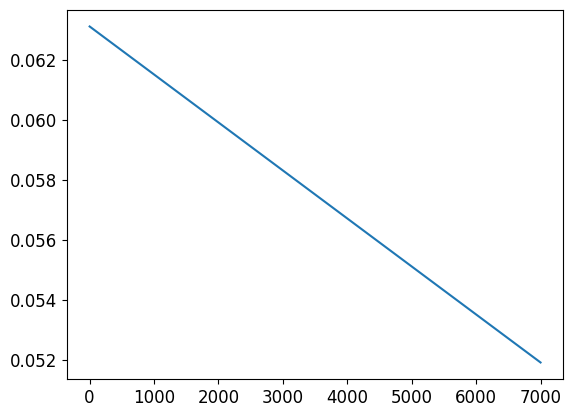

In [83]:
# plt.plot(stepsa, lossa)

In [67]:
torch.tensor([[1,2],[2,3]]).size()

torch.Size([2, 2])